*Copyright (C) 2022 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

---

# Float2Fixed Converter

_**Motivation**: In this tutorial, we will demonstrate usage of the Float2Fixed Converter for running a ProcessModels with finite precision in Lava._ 

#### This tutorial assumes that you:
- have the [Lava framework installed](../../in_depth/tutorial01_installing_lava.ipynb "Tutorial on Installing Lava")
- are familiar with the [Process concept in Lava](../../in_depth/tutorial02_processes.ipynb "Tutorial on Processes")
- are familiar with the [ProcessModel concept in Lava](../../in_depth/tutorial02_process_models.ipynb "Tutorial on ProcessModels")
- are familiar with how to [connect Lava Processes](../../in_depth/tutorial05_connect_processes.ipynb "Tutorial on connecting Processes")

This tutorial is split into two parts:<br>
First, we start with a short example of how to use `Float2FixedConverter`.<br>
Then we will go through a fully-fledged example of the entire conversion pipeline including the data needed for the actual conversion. 

## Quick introduction

In [1]:
# General imports.
import numpy as np
from matplotlib import pyplot as plt

# Imports for running the Processes in Lava.
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi1SimCfg

# Import Processes.
from lava.proc.dense.process import Dense
from lava.proc.lif.process import LIF
from lava.proc.monitor.process import Monitor

from lava.utils.float2fixed import Float2FixedConverter

We set up a simple model of forwardly connected LIF - Dense - LIF processes.

In [2]:
# Define the parameters for the floating-point ProcessModels.
lif_params = {
    'shape': (1,),
    'du': 0.1,
    'dv': 0.1,
    'bias_mant': 0.102,
    'vth': 1,
}

weight = np.array([[0.1]])


# Instantiate the Processes.
lif_1 = LIF(**lif_params)
lif_2 = LIF(**lif_params)
dense = Dense(weights=weight)

lif_1.s_out.connect(dense.s_in)
dense.a_out.connect(lif_2.a_in)

### Floating- to fixed-point conversion
To use the Float2Fixed Point converter, we need to set a `run_config` for the selection of the floating-point as well as one for the fixed-point ProcessModel.<br>
The former is used to run a floating-point version of the model to record the *range* of the dynamic variables.
This will be used to determine the range of floating-point numbers that need to be represented with coarser precision. <br>
The latter will be used to fetch implementational information about e.g. the precision of the variables in the Processes.<br>
We pass the processes as well as the number of steps for which we execute the model to the converter.

In [3]:
converter = Float2FixedConverter()
converter.set_run_cfg(fixed_pt_run_cfg=Loihi1SimCfg(select_tag='fixed_pt'),
                      floating_pt_run_cfg=Loihi1SimCfg())
converter.convert([lif_1, lif_2, dense], num_steps=200)

### Inspection of the scaled parameters
After the conversion, the converter stores the parameters for the fixed-point ProcessModel in `converter.scaled_params` in a nested dictionary. <br>
The outmost key of the dictionary is the Process ID of the converted Processes.

In [4]:
converter.scaled_params

{0: {'bias_exp': 7,
  'u': 0,
  'bias_mant': 4095,
  'vth': 80294,
  'v': 0,
  'dv': 410,
  'du': 410},
 1: {'bias_exp': 7,
  'u': 0,
  'bias_mant': 4095,
  'vth': 80294,
  'v': 0,
  'dv': 410,
  'du': 410},
 2: {'num_message_bits': 0,
  'a_buff': 0,
  'weights': array([[125]]),
  'weight_exp': 6}}

After the conversion, we are also able to inspect the distribution of the dynamic variables for the different processes using `converter.plot_var`. <br>
Here, we need to pass the ProcessID as well as the name of the Variable (see above dictionary). <br>
The red vertical lines indicate the lowest and highest value of the Variable taken into account for conversion. This can be changed by passing additional about *quantiles* to the converter. See the documentation for more details.

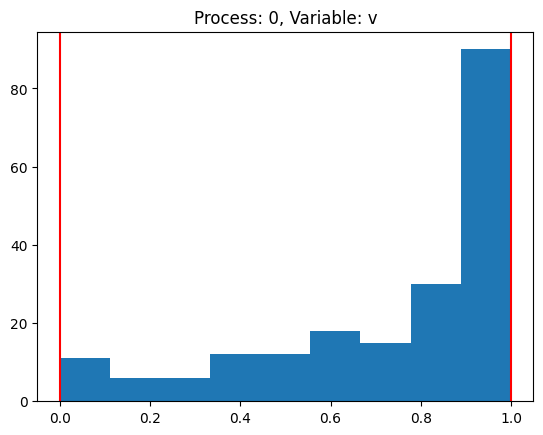

In [5]:
fig = converter.plot_var(0, 'v')

To compare the values of the variables between floating- and fixed-point ProcessModels, we need to know the scaling factors with which the Variables were scaled. <br>
These scaling factors needed for the scaling are stored in `converter.scaling_factors` in a nested dictionary. The keys are the identifier of the *scale domains* of the model.<br>
A *scale domain* is a collection of variables that are scaled with the same scaling factor. This means that these variables interact without any mediation by non-configurable constants on an identical numerical range. <br>
The identifier $0$ is special here, since it identifies the **global** *scale domain* shared across processes. All other scale domains, albeit having the same identifier, are local to a Process identified by its ID. <br>

In [6]:
converter.scaling_factors

{0: 5138823.529411765, 1: {1: 4095.0, 0: 4095.0}}

In our case, there are few local variables, and we use the inverse scaling function of the global *scale domain*.

In [7]:
inv_scaling_fct = lambda x : x / converter.scaling_factors[0]

In [8]:
run_cfg_fixed = Loihi1SimCfg(select_tag='fixed_pt')
run_cfg = Loihi1SimCfg()
run_cond = RunSteps(num_steps=200)

Next, we set up the two implementations (floating- and fixed-point) of our model with the original as well as converted parameters and execute them.

In [9]:
lif_1_fixed = LIF(**converter.scaled_params[lif_1.id], shape=(1,))
lif_2_fixed = LIF(**converter.scaled_params[lif_2.id], shape=(1,))
dense_fixed = Dense(**converter.scaled_params[dense.id])

monitor_1_fixed_u = Monitor()
monitor_1_fixed_v = Monitor()
monitor_2_fixed_u = Monitor()
monitor_2_fixed_v = Monitor()

monitor_1_fixed_u.probe(target=lif_1_fixed.u, num_steps=200)
monitor_1_fixed_v.probe(target=lif_1_fixed.v, num_steps=200)
monitor_2_fixed_u.probe(target=lif_2_fixed.u, num_steps=200)
monitor_2_fixed_v.probe(target=lif_2_fixed.v, num_steps=200)

lif_1_fixed.s_out.connect(dense_fixed.s_in)
dense_fixed.a_out.connect(lif_2_fixed.a_in)

lif_1_fixed.run(condition=run_cond, run_cfg=run_cfg_fixed)

data_1_fixed_u = monitor_1_fixed_u.get_data()[lif_1_fixed.name][lif_1_fixed.u.name]
data_1_fixed_v = monitor_1_fixed_v.get_data()[lif_1_fixed.name][lif_1_fixed.v.name]
data_2_fixed_u = monitor_2_fixed_u.get_data()[lif_2_fixed.name][lif_2_fixed.u.name]
data_2_fixed_v = monitor_2_fixed_v.get_data()[lif_2_fixed.name][lif_2_fixed.v.name]

lif_1_fixed.stop()

And now for comparison the floating-point model with the original parameters.

In [10]:
lif_1_float = LIF(**lif_params)
lif_2_float = LIF(**lif_params)
dense_float = Dense(weights=weight)

monitor_1_float_u = Monitor()
monitor_1_float_v = Monitor()
monitor_2_float_u = Monitor()
monitor_2_float_v = Monitor()

monitor_1_float_u.probe(target=lif_1_float.u, num_steps=200)
monitor_1_float_v.probe(target=lif_1_float.v, num_steps=200)
monitor_2_float_u.probe(target=lif_2_float.u, num_steps=200)
monitor_2_float_v.probe(target=lif_2_float.v, num_steps=200)

lif_1_float.s_out.connect(dense_float.s_in)
dense_float.a_out.connect(lif_2_float.a_in)

lif_1_float.run(condition=run_cond, run_cfg=run_cfg)

data_1_float_u = monitor_1_float_u.get_data()[lif_1_float.name][lif_1_float.u.name]
data_1_float_v = monitor_1_float_v.get_data()[lif_1_float.name][lif_1_float.v.name]
data_2_float_u = monitor_2_float_u.get_data()[lif_2_float.name][lif_2_float.u.name]
data_2_float_v = monitor_2_float_v.get_data()[lif_2_float.name][lif_2_float.v.name]

lif_1_float.stop()

Finally, we compare the two implementations defining the behavior. Note that we need to apply the inverse scaling to the data from the fixed point model.

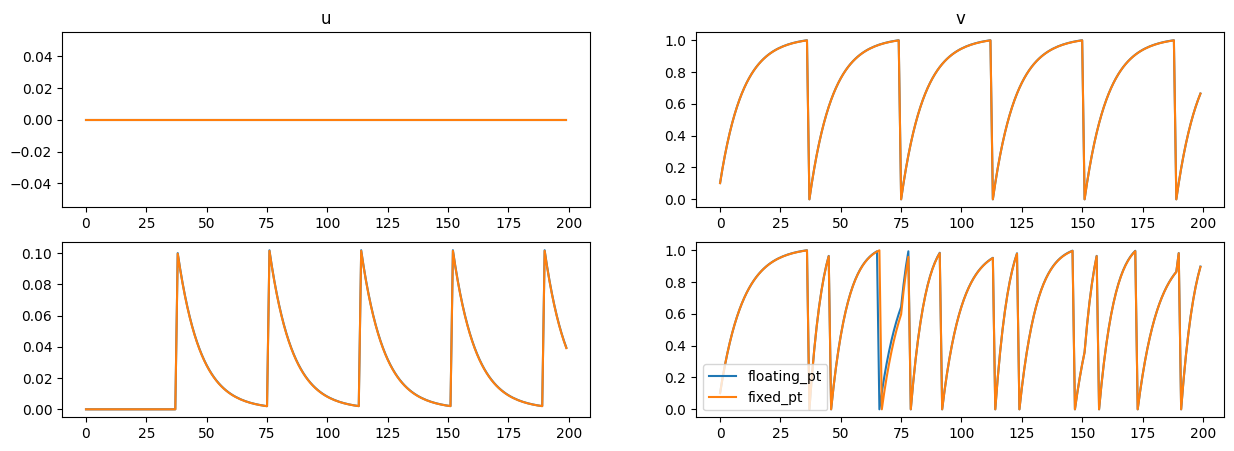

In [11]:
f, (ax1, ax2) = plt.subplots(2, 2, figsize=(15,5))
ax1[0].set_title('u')
ax1[0].plot(data_1_float_u, label='floating pt')
ax1[0].plot(inv_scaling_fct(data_1_float_u), label='fixed pt')
ax1[0].plot()
ax1[1].set_title('v')
ax1[1].plot(data_1_float_v, label='floating pt')
ax1[1].plot(inv_scaling_fct(data_1_fixed_v), label='fixed pt')
ax2[0].plot(data_2_float_u, label='floating pt')
ax2[0].plot(inv_scaling_fct(data_2_fixed_u), label='fixed pt')
ax2[1].plot(data_2_float_v, label='floating_pt')
ax2[1].plot(inv_scaling_fct(data_2_fixed_v), label='fixed_pt')
plt.legend()
plt.show()

We see a good overlap between the floating- and fixed-point values of the Variables `u` and `v`. <br>
Note, however, that with increasing model complexity and variation in dynamical variables, the correspondence gets worse.

## Full example
In the following we will consider a full example of the floating- to fixed-point conversion in Lava.<br>
This includes the definition of a Process as well as ProcessModel. The latter is used to store the relevant data for the conversion. <br>
We start by defining a LIF Process ...

In [12]:
from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.process.variable import Var
from lava.magma.core.process.ports.ports import InPort, OutPort

class CustomLIF(AbstractProcess):
    """Leaky-Integrate-and-Fire (LIF) neural Process.

    LIF dynamics abstracts to:
    u[t] = u[t-1] * (1-du) + a_in                              # neuron current
    v[t] = v[t-1] * (1-dv) + u[t] + bias_mant * 2 ** bias_exp  # neuron voltage
    s_out = v[t] > vth                                         # spike if threshold is exceeded
    v[t] = 0                                                   # reset at spike

    Parameters
    ----------
    du: Inverse of decay time-constant for current decay.
    dv: Inverse of decay time-constant for voltage decay.
    bias_mant: Mantissa part of neuron bias.
    bias_exp: Exponent part of neuron bias, if needed. Mostly for fixed point
              implementations. Unnecessary for floating point
              implementations. If specified, bias = bias_mant * 2**bias_exp.
    vth: Neuron threshold voltage, exceeding which, the neuron will spike.
    """
    def __init__(self, **kwargs):
        super().__init__()
        shape = kwargs.get("shape", (1,))
        du = kwargs.pop("du", 0)
        dv = kwargs.pop("dv", 0)
        bias_mant = kwargs.pop("bias_mant", 0)
        bias_exp = kwargs.pop("bias_exp", 0)
        vth = kwargs.pop("vth", 10)

        self.shape = shape
        self.a_in = InPort(shape=shape)
        self.s_out = OutPort(shape=shape)
        self.u = Var(shape=shape, init=0)
        self.v = Var(shape=shape, init=0)
        self.du = Var(shape=(1,), init=du)
        self.dv = Var(shape=(1,), init=dv)
        self.bias_mant = Var(shape=shape, init=bias_mant)
        self.bias_exp = Var(shape=shape, init=bias_exp)
        self.vth = Var(shape=(1,), init=vth)

... and continue with the floating-point ProcessModel ...

In [13]:
import numpy as np
from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol
from lava.magma.core.model.py.ports import PyInPort, PyOutPort
from lava.magma.core.model.py.type import LavaPyType
from lava.magma.core.model.precision import Precision
from lava.magma.core.resources import CPU
from lava.magma.core.decorator import implements, requires, tag
from lava.magma.core.model.py.model import PyLoihiProcessModel

@implements(proc=CustomLIF, protocol=LoihiProtocol)
@requires(CPU)
@tag('floating_pt')
class PyLifModelFloat(PyLoihiProcessModel):
    a_in: PyInPort = LavaPyType(PyInPort.VEC_DENSE, float)
    s_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, bool, precision=1)
    u: np.ndarray = LavaPyType(np.ndarray, float)
    v: np.ndarray = LavaPyType(np.ndarray, float)
    bias_mant: np.ndarray = LavaPyType(np.ndarray, float)
    bias_exp: np.ndarray = LavaPyType(np.ndarray, float)
    du: float = LavaPyType(float, float)
    dv: float = LavaPyType(float, float)
    vth: float = LavaPyType(float, float)

    def run_spk(self):
        a_in_data = self.a_in.recv()
        self.u[:] = self.u * (1 - self.du)
        self.u[:] += a_in_data
        bias = self.bias_mant * (2 ** self.bias_exp)
        self.v[:] = self.v * (1 - self.dv) + self.u + bias
        s_out = self.v >= self.vth
        self.v[s_out] = 0  # Reset voltage to 0.
        self.s_out.send(s_out)

... as well as the fixed-point ProcessModel.<br>
In the fixed-point model we need to specify the data needed for conversion. This is conveyed in the LavaPyType.<br>
The following arguments are needed:
* **precision** - specifies the precision of the fixed-point representation communicated via a `Precision` data class which has members:  
    * `is_signed` - bool indicating if representation is signed or unsigned
    * `num_bits` - number of bits of the fixed-point representation
    * `implicit_shift` - realigning of significant point of variables in fixed-point representation by multiplication of $2^{\mathrm{implicit shift}}$
* **scale_domain** - set *scale domain* (see above). Default is `0`, i.e., the global scale domain.
* **constant** - bool indicating whether the variable is constant, i.e., does not change during execution. Default is `False`.
* **meta_parameter** - bool indicating whether a variable needs to be converted, e.g., parameters setting a mode. Default is `False`.
* **num_bits_exp** - int indicating how many bits are available for exponent if variable representations are split into mantissa and exponent: $v_{mant} \cdot 2 ^ {v_{exp}}$. Default is `None`.
* **exp_var** - name of variable storing the exponent of above split representation. Default is `None`.

In [14]:
@implements(proc=CustomLIF, protocol=LoihiProtocol)
@requires(CPU)
@tag('fixed_pt')
class PyLifModelFixed(PyLoihiProcessModel):
    a_in: PyInPort = LavaPyType(PyInPort.VEC_DENSE, np.int64,
                                precision=Precision(is_signed=True,
                                                    num_bits=16,
                                                    implicit_shift=6))
    s_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, bool,
                                  precision=Precision(is_signed=False,
                                                      num_bits=1,
                                                      implicit_shift=0))
    u: np.ndarray = LavaPyType(np.ndarray, np.int64,
                               precision=Precision(is_signed=True,
                                                   num_bits=24,
                                                   implicit_shift=0))
    v: np.ndarray = LavaPyType(np.ndarray, np.int64,
                               precision=Precision(is_signed=True,
                                                   num_bits=24,
                                                   implicit_shift=0))
    bias_mant: np.ndarray = LavaPyType(np.ndarray, np.int64, constant=True,
                                       precision=Precision(is_signed=True,
                                                           num_bits=13,
                                                           implicit_shift=0),
                                       num_bits_exp=3, exp_var='bias_exp')
    bias_exp: np.ndarray = LavaPyType(np.ndarray, np.int64, meta_parameter=True)
    du: int = LavaPyType(int, np.uint64, precision=Precision(is_signed=False,
                                                             num_bits=12,
                                                             implicit_shift=0), 
                         scale_domain=1, domain=np.array([0,1]), constant=True)
    dv: int = LavaPyType(int, np.uint64, precision=Precision(is_signed=False,
                                                             num_bits=12,
                                                             implicit_shift=0),
                         scale_domain=1, domain=np.array([0,1]), constant=True)
    vth: int = LavaPyType(int, np.int64, constant=True,
                          precision=Precision(is_signed=False,
                                              num_bits=17,
                                              implicit_shift=6))
        
    a_in_shift: int = 6
    v_th_shift: int = 6

    def run_spk(self):
        a_in_data = np.left_shift(self.a_in.recv(), self.a_in_shift) # Apply implicit shift.
        # Application of decay happens on own scale domain.
        self.u[:] = np.right_shift(self.u * (2 ** 12 - self.du), 12)
        self.u[:] += a_in_data
        bias = self.bias_mant * (2 ** self.bias_exp)
        # Application of decay happens on own scale domain, same as du.
        self.v[:] = np.right_shift(self.v * (2 ** 12 - self.dv), 12)
        self.v[:] += self.u + bias
        s_out = self.v >= np.left_shift(self.vth, self.v_th_shift) # Apply implicit shift to vth.
        self.v[s_out] = 0  
        self.s_out.send(s_out)

Next, we instantiate a `CustomLIF` Process that we want to be convert.

In [15]:
# Define the parameters for the floating-point ProcessModels.
lif_params = {
    'shape': (1,),
    'du': 0.1,
    'dv': 0.1,
    'bias_mant': 0.102,
    'vth': 1,
}

lif_conv = CustomLIF(**lif_params)

In [16]:
# Convert the parameters.
converter = Float2FixedConverter()
converter.set_run_cfg(fixed_pt_run_cfg=Loihi1SimCfg(select_tag='fixed_pt'),
                      floating_pt_run_cfg=Loihi1SimCfg(select_tag='floating_pt'))
converter.convert(lif_conv, num_steps=200)

In [17]:
# Define scaling function and inspect the mapped parameters.
inv_scaling_fct = lambda x: x / converter.scaling_factors[0]

converter.scaled_params

{22: {'bias_exp': 7,
  'u': 0,
  'bias_mant': 4095,
  'vth': 80294,
  'v': 0,
  'dv': 410,
  'du': 410}}

Finally, we again assess the floating- to fixed-point conversion. <br>
First the floating-point ...

In [18]:
lif = CustomLIF(**lif_params)

monitor_float_u = Monitor()
monitor_float_v = Monitor()

monitor_float_u.probe(target=lif.u, num_steps=200)
monitor_float_v.probe(target=lif.v, num_steps=200)

lif.run(condition=run_cond, run_cfg=Loihi1SimCfg(select_tag='floating_pt'))

data_float_u = monitor_float_u.get_data()[lif.name][lif.u.name]
data_float_v = monitor_float_v.get_data()[lif.name][lif.v.name]


lif.stop()

... and then the fixed-point model.

In [19]:
lif = CustomLIF(**converter.scaled_params[lif_conv.id])

monitor_fixed_u = Monitor()
monitor_fixed_v = Monitor()

monitor_fixed_u.probe(target=lif.u, num_steps=200)
monitor_fixed_v.probe(target=lif.v, num_steps=200)

lif.run(condition=run_cond, run_cfg=Loihi1SimCfg(select_tag='fixed_pt'))

data_fixed_u = monitor_fixed_u.get_data()[lif.name][lif.u.name]
data_fixed_v = monitor_fixed_v.get_data()[lif.name][lif.v.name]


lif.stop()

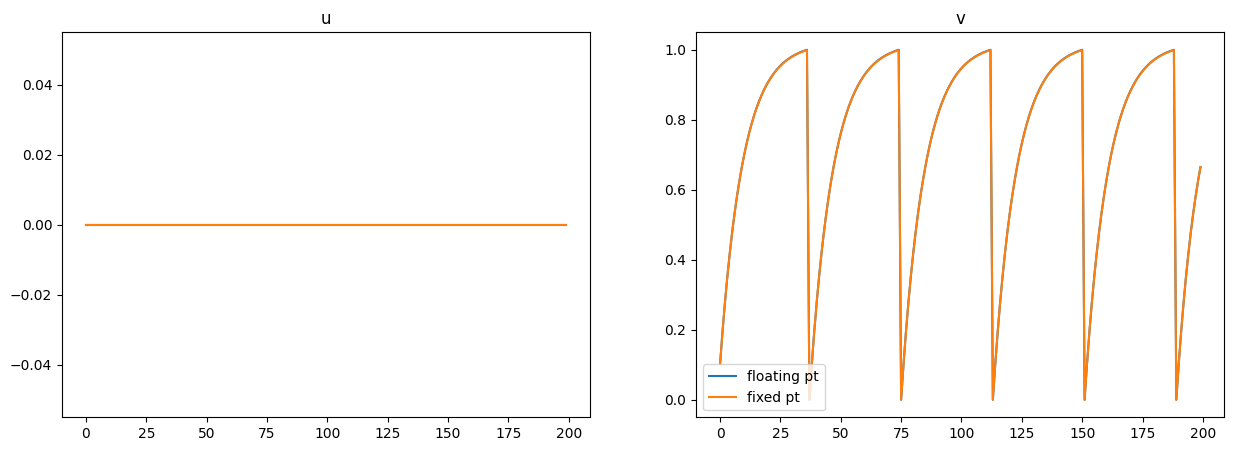

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.set_title('u')
ax1.plot(data_float_u, label='floating pt')
ax1.plot(inv_scaling_fct(data_fixed_u), label='fixed pt')

ax2.set_title('v')
ax2.plot(data_float_v, label='floating pt')
ax2.plot(inv_scaling_fct(data_fixed_v), label='fixed pt')

plt.legend()
plt.show()